# Density Tests

In this notebook we will be getting densities of the adjacency matrices representing the neurons in different sections of the larva (hemispheres and segments). We will then test if there is any statistical significance between the densities across hemispheres/segments.

In [190]:
import pymaid
import os
import logging
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import seaborn as sns
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from networkx import from_numpy_array, from_pandas_adjacency, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component, is_symmetric, symmetrize
from graspologic.inference import erdos_renyi_test
from statsmodels.stats.proportion import proportion_confint
from pkg.platy import _get_folder, load_connectome_lcc_annotations, load_connectome_lcc_adj

In [191]:
# rm = pymaid.CatmaidInstance(
#     server="https://catmaid.jekelylab.ex.ac.uk/#",
#     project_id=11,
#     api_token=None,
#     http_user=None,
#     http_password=None,
# )
# logging.getLogger("pymaid").setLevel(logging.WARNING)
# pymaid.clear_cache()

# path = "/Users/kareefullah/Desktop/neurodata/neurodata/platy-data/docs/outputs"


Let us first import the annotations table that we made in the `data_summary_v2.ipynb` file

In [192]:
folder = _get_folder()
annotations = load_connectome_lcc_annotations()
annotations = annotations.fillna("N/A")

connec_lcc_adj = load_connectome_lcc_adj()

For the left and right hemispheres, we make a dictionary where the keys are the annotations `"l"` and `"r"` and the values are the skids that have the respective annotation

In [193]:
hemi_skid_dict = {"l": [], "r": []}
hemi_list = list(annotations["side"])
skids_list = list(annotations["skids"])
for i in range(len(hemi_list)):
    if hemi_list[i] == "N/A":
        continue
    
    if hemi_list[i] in hemi_skid_dict:
        hemi_skid_dict[hemi_list[i]].append(str(skids_list[i]))

For the segments, we make another dictionary where the keys are the annotations `"head" and "pygidium" and "0" and "1" and "2" and "3"` and the values are the skids that have the respective annotation

In [194]:
#use annotations to get skids for segments
segment_skid_dict = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
segment_list = list(annotations["segment"])
skids_list = list(annotations["skids"])
for i in range(len(segment_list)):
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] in segment_skid_dict:
        segment_skid_dict[segment_list[i]].append(str(skids_list[i]))

We now make respective adjacency matrices for the skids for each hemisphere

In [195]:
#use for loops to avoid repetition
df_hemis = {"l": None, "r": None}
print(annotations.index)
for key in hemi_skid_dict:
    df_hemis[key] = connec_lcc_adj.loc[hemi_skid_dict[key], hemi_skid_dict[key]]

RangeIndex(start=0, stop=2723, step=1)


We do the same here for the skids of the segments

In [196]:
df_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in segment_skid_dict:
    df_segments[key] = connec_lcc_adj.loc[segment_skid_dict[key], segment_skid_dict[key]]

We convert the adjacency matrices to networkx objects so we can get the density of these graphs

In [197]:
nx_hemis = {"l": None, "r": None}
for key in df_hemis:
    nx_hemis[key] = from_pandas_adjacency(df_hemis[key], create_using=nx.DiGraph)

In [198]:
nx_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in df_segments:
    nx_segments[key] = from_pandas_adjacency(df_segments[key], create_using=nx.DiGraph)

We then get the densities of these networkx graphs

In [199]:
dens_hemis = {"l": None, "r": None}
for key in nx_hemis:
    dens_hemis[key] = density(nx_hemis[key])

In [200]:
dens_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in nx_segments:
    dens_segments[key] = density(nx_segments[key])

We concatenate the dicts so we can get a barplot of all the dictionaries we have

In [201]:
all_dicts = dens_hemis | dens_segments

In [202]:
labels = list(all_dicts.keys())
densities = list(all_dicts.values())

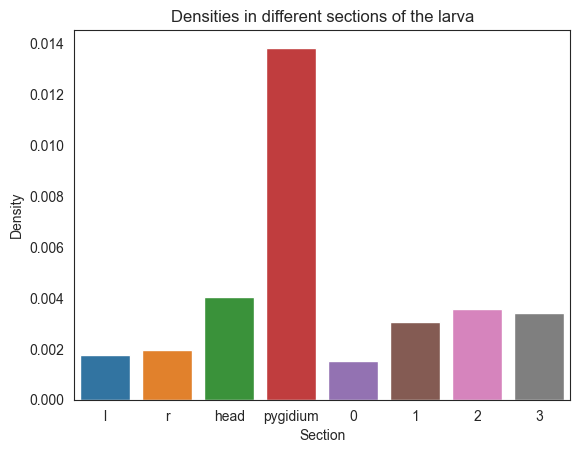

In [215]:
sns.set_style("white")
sns.barplot(x=labels, y=densities) 
plt.title("Densities in different sections of the larva")
plt.xlabel("Section")
plt.ylabel("Density")
plt.savefig(folder / "densities_sections")

In [204]:
#pass in misc of the pairwise test, the labels of the 
def plot_barplot(networks, labels, densities, coverage=0.95, name="hemis"):
    plt.figure(figsize=(6, 6))
    ax = sns.barplot(x=labels, y=densities)
    ax.set_title("Densities in different sections of the larva")
    ax.set_xlabel("Section")
    ax.set_ylabel("Density")
    #get possible number of edges, number of edges
    possible_edges = []
    num_edges = []
    for i, network in enumerate(networks.values()):
        #possible edges
        n = np.shape(network)[0]
        n_possible = n * (n-1)
        possible_edges.append(n_possible)

        #number of edges
        num_edges.append(np.count_nonzero(network))

    #upper and lower bound for each network
    bounds = []
    for poss, num in zip(possible_edges, num_edges):
        lower, upper = proportion_confint(num, poss, alpha=1-coverage, method="beta")
        bounds.append([lower, upper])
    
    halfwidth = 0.1
    linewidth = 2
    colors = sns.color_palette("Set1")
    palette = {}
    for i, label in enumerate(labels):
        palette[label] = colors[i]
    
    #plot confidence intervals
    for x, bound in enumerate(bounds):
        color = palette[labels[x]]
        ax.plot([x, x], [bounds[x][0], bounds[x][1]], color=color, linewidth=linewidth)
        x += 1
    

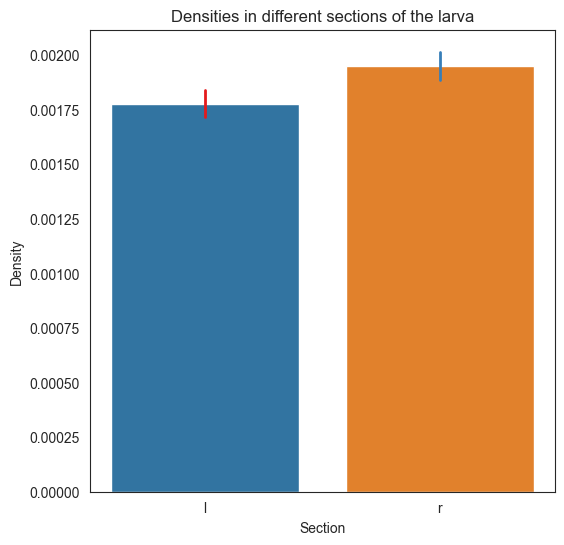

In [216]:
#bar plot for dens_hemis with confidence intervals
hemi_labels = list(dens_hemis.keys())
hemi_densities = list(dens_hemis.values())

#run er test to get misc dict to plot confidence intervals
#convert pandas df to numpy
np_hemis = {"l": None, "r": None}
for key in df_hemis:
    np_hemis[key] = df_hemis[key].to_numpy()
plot_barplot(np_hemis, hemi_labels, hemi_densities)
plt.savefig(folder / "densities_hemis")

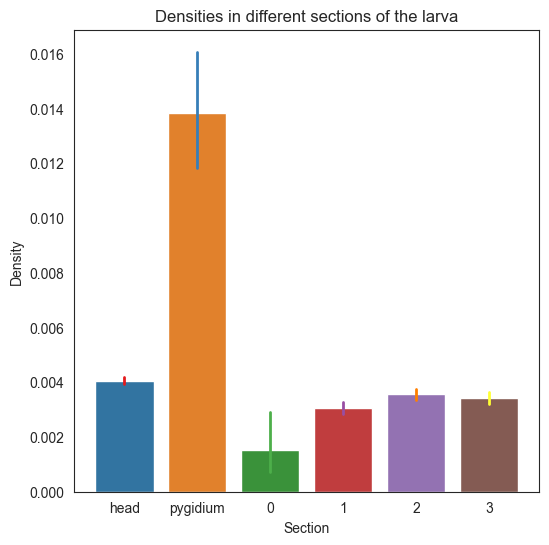

In [206]:
#bar plot for dens_segments with confidence intervals
segment_labels = list(dens_segments.keys())
segment_densities = list(dens_segments.values())

#run er test to get misc dict to plot confidence intervals
#convert pandas df to numpy

np_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in df_segments:
    np_segments[key] = df_segments[key].to_numpy()
plot_barplot(np_segments, segment_labels, segment_densities)
plt.savefig(folder / "densities_segments")

Let's now run the test for the left and right hemisphere

In [207]:
#print p val of er test of left vs right
stats_hemis, pval_hemis, misc_hemis = erdos_renyi_test(np_hemis["l"], np_hemis["r"])
print(pval_hemis)

0.00013761343409455663


We see that the pvalue is very small, which means that we reject the null hypothesis that the edge probability for the adj of the left hemisphere is not different from the edge probability of the adj of the right hemisphere

In [208]:
#6 by 6 df of pvals of the segments
labels_segments = list(dens_segments.keys())
adj_list = list(np_segments.values())
#densities_segments = list(dens_segments.values())

#make pairwise combination list of all elements in list 
pairwise_labels = list(itertools.combinations(labels_segments, 2))
pairwise_adjs = list(itertools.combinations(adj_list, 2))
#pairwise_dens = list(itertools.combinations(densities_segments, 2))

#initialize dataframe
names = ["head", "pygidium", "0", "1", "2", "3"]
zero_data = np.zeros(shape=(len(names), len(names)))
pval_df = pd.DataFrame(zero_data, columns=names, index=names)
pval_list = []
for label, adjs in zip(pairwise_labels, pairwise_adjs):
    stat, pval, misc = erdos_renyi_test(adjs[0], adjs[1])
    pval_df[label[0]][label[1]] = pval
    pval_df[label[1]][label[0]] = pval
pval_df.to_csv(folder / "er_pvals_segments.csv")
pval_df


,head,pygidium,0,1,2,3
head,0.000000e+00,9.649905e-40,1.200484e-03,5.160869e-13,7.972045e-05,3.456650e-06
pygidium,9.649905e-40,0.000000e+00,4.823020e-19,1.519026e-51,6.562790e-45,3.239173e-46
0,1.200484e-03,4.823020e-19,0.000000e+00,3.894585e-02,7.133094e-03,1.145437e-02
1,5.160869e-13,1.519026e-51,3.894585e-02,0.000000e+00,8.803506e-04,2.711660e-02
2,7.972045e-05,6.562790e-45,7.133094e-03,8.803506e-04,0.000000e+00,3.224518e-01
3,3.456650e-06,3.239173e-46,1.145437e-02,2.711660e-02,3.224518e-01,0.000000e+00


The following methods will allow us to plot the density of the sections that we are interested in, as well as the pvalue after running the `erdos_renyi_test`

In [209]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [210]:
def plot_density(pval, label1, label2, misc, ax=None, coverage=0.95):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))

    n_possible_first = misc["possible1"]
    n_possible_second = misc["possible2"]

    density_first = misc["probability1"]
    density_second = misc["probability2"]

    n_edges_first = misc["observed1"]
    n_edges_second = misc["observed2"]

    first_lower, first_upper = proportion_confint(
        n_edges_first, n_possible_first, alpha=1 - coverage, method="beta"
    )
    second_lower, second_upper = proportion_confint(
        n_edges_second, n_possible_second, alpha=1 - coverage, method="beta"
    )

    halfwidth = 0.1
    linewidth = 4
    colors = sns.color_palette("Set2")
    palette = dict(zip([label1, label2], [colors[0], colors[1]]))

    color = palette[label1]
    x = 0
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_first, density_first],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [first_lower, first_upper], color=color, linewidth=linewidth)

    color = palette[label2]
    x = 1
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_second, density_second],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [second_lower, second_upper], color=color, linewidth=linewidth)

    #yticks = [np.round(density_left, 4), np.round(density_right, 4)]
    yticks = [density_first, density_second]
    ax.set(
        xlabel="Section",
        xticks=[0, 1],
        xticklabels=[label1, label2],
        xlim=(-0.5, 1.5),
        yticks=yticks,
        # ylim=(0, max(right_upper, left_upper) * 1.05),
        ylabel=r"Estimated density ($\hat{p}$)",
        title="{} vs {}; pval: {}".format(label1, label2, pval)
    )
    scale = 0.04
    line_shift = 0.000005
    max_upper = max(first_upper, second_upper)
    line_start = max_upper + line_shift
    y_shift = max_upper * scale
    ax.plot([label1, label1, label2, label2], [max_upper+line_shift, max_upper+y_shift, max_upper+y_shift, max_upper+line_shift])
    text = convert_pvalue_to_asterisks(pval)
    
    x_text = 0.5
    y_text = max_upper+y_shift
    ax.text(x_text, y_text, text, ha='center', va='bottom')
    labels = ax.get_xticklabels()
    for label in labels:
        text_string = label.get_text()
        label.set_color(palette[text_string])
    return ax.get_figure(), ax

We plot the densities for adjs of the left and right hemisphere

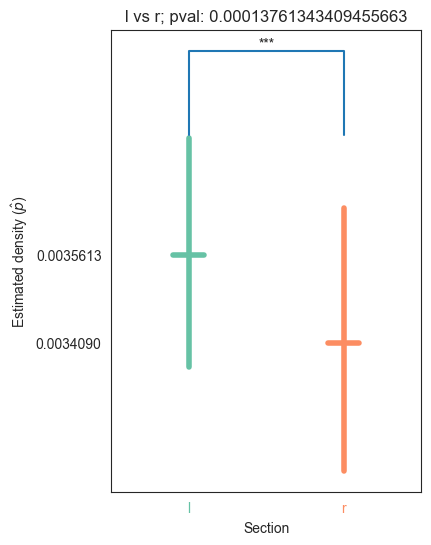

In [214]:
plot_density(pval_hemis, list(np_hemis.keys())[0], list(np_hemis.keys())[1], misc)
plt.savefig(folder / "density_plots/{} vs {}".format("left", "right"), bbox_inches='tight')


To make comparisons for the segments, we will make two lists: one that has every pairwise combination of the segment names and the other of the pairwise combination of the respective adjs

In [212]:
keys = list(np_segments.keys())
vals = list(np_segments[key] for key in keys)
keys = list(itertools.combinations(keys, 2))
vals = list(itertools.combinations(vals, 2))

We plot the densities of all the pairwise combinations of segments, and note that segment 1 vs 3 is the only test that yields a non-significant p-value, which indicates that we fail to reject the null hypothesis that segment 1 and 3 have the same network density

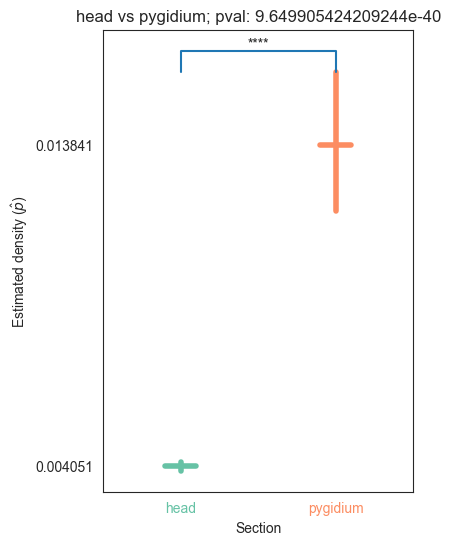

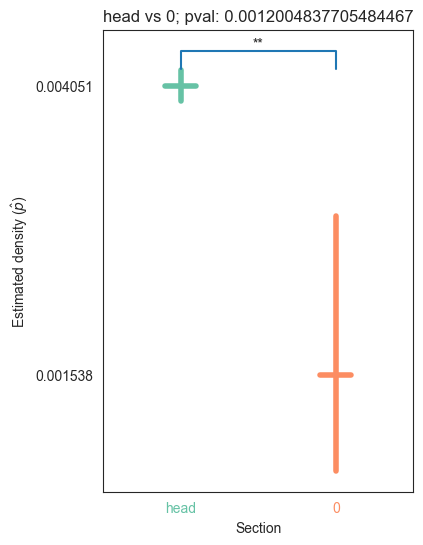

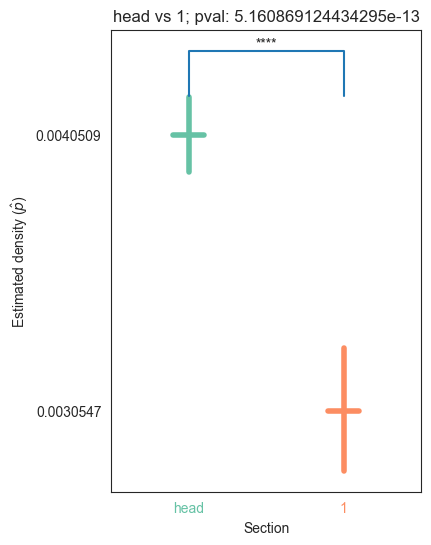

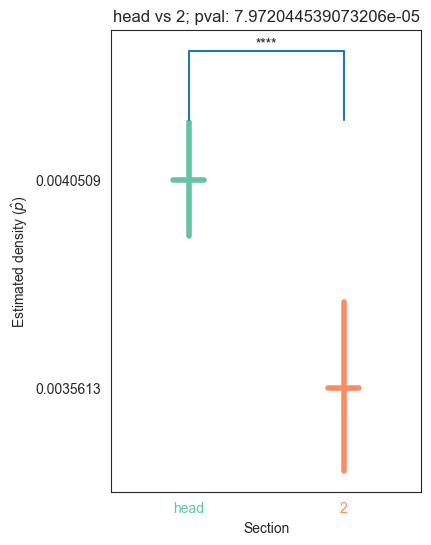

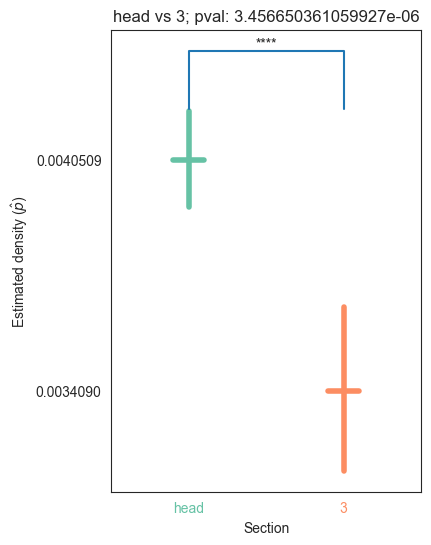

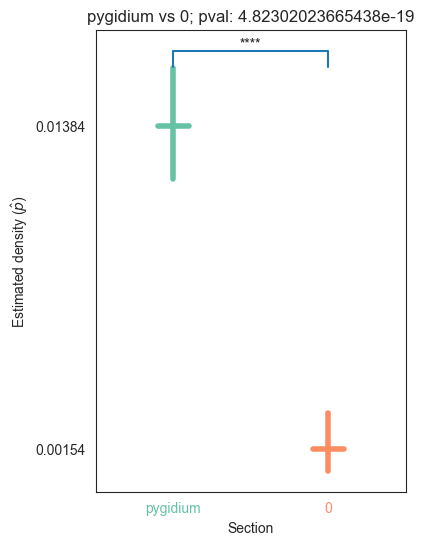

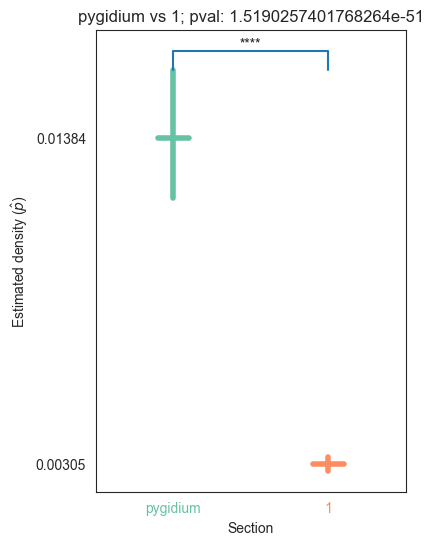

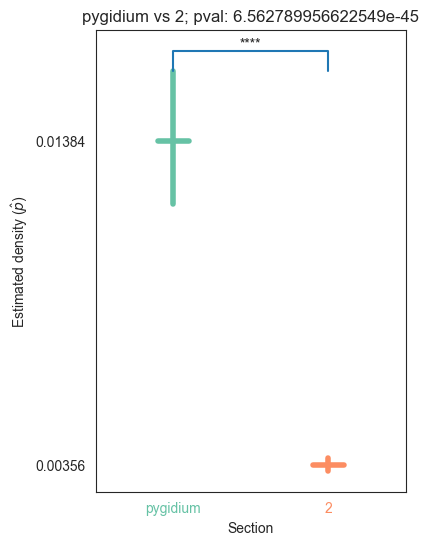

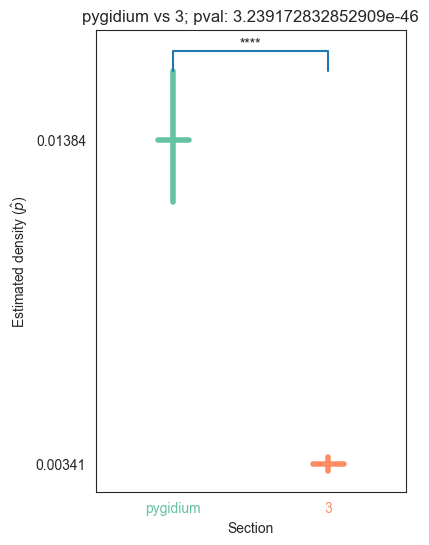

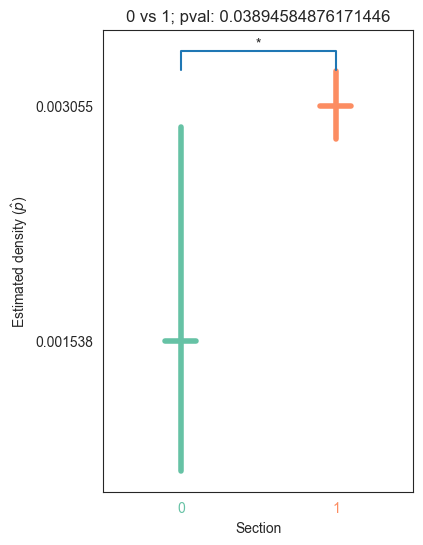

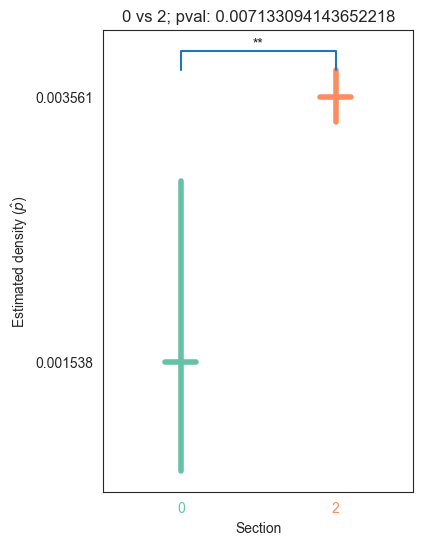

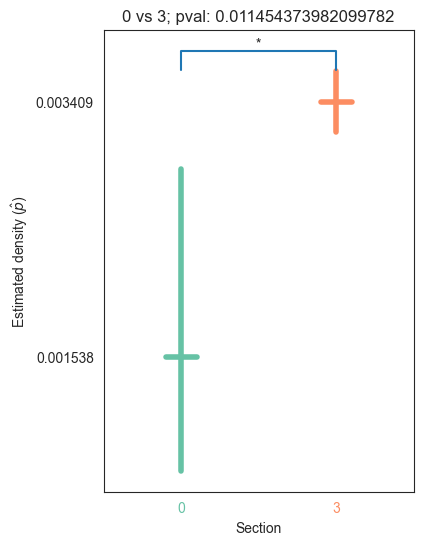

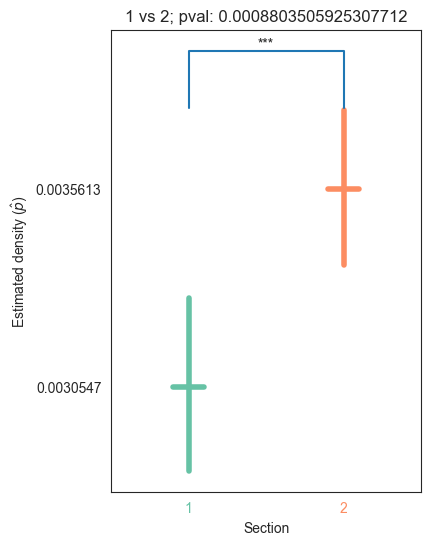

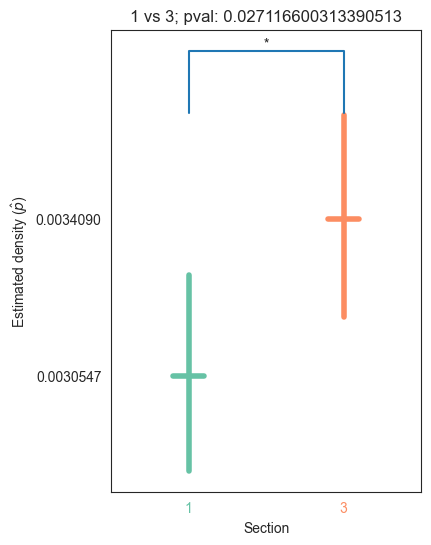

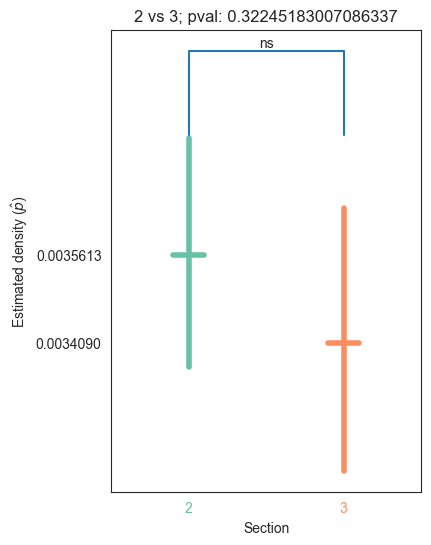

In [213]:
for pair_key, pair_val in zip(keys, vals):
    stat, pval, misc = erdos_renyi_test(pair_val[0], pair_val[1])
    plot_density(pval, pair_key[0], pair_key[1], misc)
    plt.savefig(folder / "density_plots" / "{} vs {}".format(pair_key[0], pair_key[1]), bbox_inches='tight')